In [50]:
import os
import pandas as pd

In [51]:
data_dir = "data"
data_folder = "aclImdb"
data_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"
sample_idx = 42
cache_dir = os.path.join("cache", "sentiment_analysis")
pytorch_dir = 'data/pytorch' # The folder we will use for storing data

### Step 1: Downloading the data

In [52]:
import tarfile
from urllib.request import urlretrieve
from pathlib import Path

def download_data(data_dir, data_url, filename):
    Path(data_dir).mkdir(parents=True, exist_ok=True)
    download = urlretrieve(url=data_url, filename=Path(data_dir).joinpath(filename))
    tar = tarfile.open(name=download[0], mode='r|*')
    tar.extractall(data_dir)
    tar.close()

In [53]:
download_data(data_dir, data_url, filename)

In [54]:
import os
import glob
from pathlib import Path

def read_imdb_data(data_dir, data_folder):
    imdb_dir = Path(data_dir).joinpath(data_folder)
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(imdb_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [55]:
data, labels = read_imdb_data(data_dir, data_folder)

In [56]:
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [57]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [58]:
train_valid_X, test_X, train_valid_y, test_y = prepare_imdb_data(data, labels)

In [59]:
from sklearn.model_selection import train_test_split

def split_train_validation_data(train_valid_X, train_valid_y, valid_size=0.3, random_state=42):
    train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X,
                                                          train_valid_y, 
                                                          test_size=valid_size, 
                                                          random_state=random_state)
    return train_X, valid_X, train_y, valid_y

In [60]:
train_X, valid_X, train_y, valid_y = split_train_validation_data(train_valid_X, train_valid_y, valid_size=0.3)

In [61]:
print("IMDb reviews (combined): train = {}, valid = {}, test = {}".format(len(train_X), len(valid_X),len(test_X)))

IMDb reviews (combined): train = 17500, valid = 7500, test = 25000


In [62]:
print(f"sentiment: {train_y[sample_idx]}")
print(f"review: {train_X[sample_idx]}")

sentiment: 0
review: This was the worst film i have seen for a long time. <br /><br />Not only that it has nearly nothing to do with the other American Pie movies, the story is obvious, flat and absolutely not funny. <br /><br />The girls are nice though, but spending your time watching a cheap soft porno would possibly be greater than watching this film.<br /><br />This film seems to be a very bad made sex ad, made for an audience that is not older than 12.<br /><br />I never visited an American college, but i would seriously doubt that anyone who did could really laugh about any of the scenes.<br /><br />Save your time, do something else.


In [63]:
print(f"sentiment: {valid_y[sample_idx]}")
print(f"review: {valid_X[sample_idx]}")

sentiment: 1
review: I have seen virtually all of Cynthia Rothrock's films, and to me this is the funniest. It reminds me of early Jackie Chan movies. Admittedly, Ms Rothrock may not be the greatest actress, but she is very good to watch as both a martial artist and as a very cute young lady. This film, while probably not the best of all her films, was the most entertaining.


In [64]:
print(f"sentiment: {test_y[sample_idx]}")
print(f"review: {test_X[sample_idx]}")

sentiment: 0
review: I don't know how people can watch this - the only people who enjoy watching this are those who have no feelings and emotions and enjoy watching people die, houses burn down, car crashes, babies die, and cast members being killed off every week. Its the most absurd thing on television and i still don't know how it pulls in the ratings. Its so depressing. I can imagine the writers sitting down and saying - 'so who shall we kill of next week then' or 'whose house shall we torch in a months time?'<br /><br />Its the most depressing, absurd and most stupid thing on TV at the moment, and i cant understand peoples motives for watching this depressing pile of crap anymore


In [65]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [66]:
print(review_to_words(train_X[sample_idx]))

['worst', 'film', 'seen', 'long', 'time', 'nearli', 'noth', 'american', 'pie', 'movi', 'stori', 'obviou', 'flat', 'absolut', 'funni', 'girl', 'nice', 'though', 'spend', 'time', 'watch', 'cheap', 'soft', 'porno', 'would', 'possibl', 'greater', 'watch', 'film', 'film', 'seem', 'bad', 'made', 'sex', 'ad', 'made', 'audienc', 'older', '12', 'never', 'visit', 'american', 'colleg', 'would', 'serious', 'doubt', 'anyon', 'could', 'realli', 'laugh', 'scene', 'save', 'time', 'someth', 'els']


In [67]:
print(review_to_words(valid_X[sample_idx]))

['seen', 'virtual', 'cynthia', 'rothrock', 'film', 'funniest', 'remind', 'earli', 'jacki', 'chan', 'movi', 'admittedli', 'ms', 'rothrock', 'may', 'greatest', 'actress', 'good', 'watch', 'martial', 'artist', 'cute', 'young', 'ladi', 'film', 'probabl', 'best', 'film', 'entertain']


In [68]:
print(review_to_words(test_X[sample_idx]))

['know', 'peopl', 'watch', 'peopl', 'enjoy', 'watch', 'feel', 'emot', 'enjoy', 'watch', 'peopl', 'die', 'hous', 'burn', 'car', 'crash', 'babi', 'die', 'cast', 'member', 'kill', 'everi', 'week', 'absurd', 'thing', 'televis', 'still', 'know', 'pull', 'rate', 'depress', 'imagin', 'writer', 'sit', 'say', 'shall', 'kill', 'next', 'week', 'whose', 'hous', 'shall', 'torch', 'month', 'time', 'depress', 'absurd', 'stupid', 'thing', 'tv', 'moment', 'cant', 'understand', 'peopl', 'motiv', 'watch', 'depress', 'pile', 'crap', 'anymor']


In [69]:
import pickle
from tqdm import tqdm


os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists
def preprocess_data(data_train, data_test, data_valid, 
                    labels_train, labels_test, labels_valid,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in tqdm(data_train)]
        words_valid = [review_to_words(review) for review in tqdm(data_valid)]
        words_test = [review_to_words(review) for review in tqdm(data_test)]
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,words_valid=words_valid,
                              labels_train=labels_train, labels_test=labels_test, labels_valid=labels_valid)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, words_valid, labels_train, labels_test, labels_valid = (cache_data['words_train'],
                cache_data['words_test'], cache_data['words_valid'], 
                cache_data['labels_train'], cache_data['labels_test'], cache_data['labels_valid'])
    return words_train, words_test, words_valid, labels_train, labels_test, labels_valid

In [70]:
train_pp_X, test_pp_X, valid_pp_X, train_pp_y, test_pp_y, valid_pp_y = preprocess_data(train_X, test_X, valid_X,
                                                                           train_y, test_y, valid_y)

Read preprocessed data from cache file: preprocessed_data.pkl


In [71]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.

    flatten_data = [word for review in data for word in review]
    (unique, counts) = np.unique(flatten_data, return_counts=True)   

    # word_count = {}
    # A dict storing the words that appear in the reviews along with how often they occur
    word_count = zip_word_count = {x:y for x,y in zip(unique, counts)}
    
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    #sorted_zip_word_count = [{key: value} for (key, value) in sorted(zip_word_count.items(), key=lambda x: x[1], reverse=True)]
    #sorted_words = dict((key, val) for k in sorted_zip_word_count for key, val in k.items())
    sorted_words = list(key for (key, value) in sorted(zip_word_count.items(), key=lambda x: x[1], reverse=True))
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
         word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict, sorted_words, word_count

In [80]:
word_dict, sorted_words, word_count = build_dict(train_pp_X)

In [82]:
words_to_remove = ["movi", "film", "one"]

In [83]:
for word in words_to_remove:
    word_dict.pop(word)

In [88]:
new_vocab_size = len(word_dict)

In [84]:
pd.DataFrame(word_count.items(), columns = ["word", "count"]).sort_values(by="count",ascending=False).head(20)

,word,count
26222,movi,36240
13990,film,33543
28037,one,19432
22751,like,16009
39435,time,11280
16155,good,10781
23859,make,10597
34529,see,9948
42723,watch,9878
15647,get,9817


In [89]:
if not os.path.exists(pytorch_dir): # Make sure that the folder exists
    os.makedirs(pytorch_dir)

In [90]:
with open(os.path.join(pytorch_dir, 'word_dict_enhanced.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [91]:
import numpy as np

def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in tqdm(data,leave=True):
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [92]:
train_tf_X, train_X_tf_len = convert_and_pad_data(word_dict, train_pp_X)

100%|██████████| 17500/17500 [00:00<00:00, 30257.24it/s]


In [93]:
test_tf_X, test_X_tf_len = convert_and_pad_data(word_dict, test_pp_X)

100%|██████████| 25000/25000 [00:00<00:00, 28629.70it/s]


In [94]:
valid_tf_X, valid_X_tf_len = convert_and_pad_data(word_dict, valid_pp_X)

100%|██████████| 7500/7500 [00:00<00:00, 31735.25it/s]


In [97]:
import pandas as pd
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_tf_len), pd.DataFrame(train_tf_X)], axis=1) \
        .to_csv(os.path.join(pytorch_dir, 'train.csv'), header=False, index=False)

pd.concat([pd.DataFrame(valid_y), pd.DataFrame(valid_X_tf_len), pd.DataFrame(valid_tf_X)], axis=1) \
        .to_csv(os.path.join(pytorch_dir, 'valid.csv'), header=False, index=False)

In [98]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session(boto_session=boto3.session.Session(region_name="us-east-1"))

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

try:
    role = sagemaker.get_execution_role()
except Exception as err:
    role = "arn:aws:iam::977053370764:role/service-role/AmazonSageMaker-ExecutionRole-20201202T141643"

Couldn't call 'get_role' to get Role ARN from role name aadelmo to get Role path.


In [99]:
input_data = sagemaker_session.upload_data(path=pytorch_dir, bucket=bucket, key_prefix=prefix)
input_data

's3://sagemaker-us-east-1-977053370764/sagemaker/sentiment_rnn'

In [100]:
import torch
import torch.utils.data

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(pytorch_dir, 'train.csv'), header=None, names=None, nrows=250)
valid_sample = pd.read_csv(os.path.join(pytorch_dir, 'valid.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

valid_sample_y = torch.from_numpy(valid_sample[[0]].values).float().squeeze()
valid_sample_X = torch.from_numpy(valid_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
valid_sample_ds = torch.utils.data.TensorDataset(valid_sample_X, valid_sample_y)

# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)
valid_sample_dl = torch.utils.data.DataLoader(valid_sample_ds, batch_size=50)

In [101]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

def train(model, train_loader, valid_loader, epochs, optimizer, loss_fn, device):
    report_train = pd.DataFrame(columns=["epoch", "trainError", "validError"])
    best_valid_BCELoss = 9999999999
    BCELoss_list = []
    valid_BCELoss_list = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        total_loss = 0
        total_valid_loss = 0        
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # TODO: Complete this train method to train the model provided.
            optimizer.zero_grad()
            output = model(batch_X)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()            
            total_loss += loss.data.item()
        for block in valid_loader:     
            block_X, block_y = block
            
            block_X = block_X.to(device)
            block_y = block_y.to(device)
            output_valid = model(block_X)
            valid_loss = loss_fn(output_valid, block_y)
            total_valid_loss += valid_loss.data.item()
        BCELoss = total_loss/len(train_loader)
        BCELoss_list.append(BCELoss)
        valid_BCELoss = total_valid_loss/len(valid_loader)
        valid_BCELoss_list.append(valid_BCELoss)
        if valid_BCELoss < best_valid_BCELoss: 
            dummy_input = torch.tensor(block_X).to(device).long()
            torch.onnx.export(model, dummy_input, f"models/best_model.onnx")
            best_valid_BCELoss = BCELoss
        
        desc = (f'Epoch: {epoch}, train_loss: {BCELoss}, valid_loss: {valid_BCELoss}')
        print(desc)
        to_append = [epoch, BCELoss, valid_BCELoss]
        report_train_length = len(report_train)
        report_train.loc[report_train_length] = to_append
        #print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))
        display.clear_output(wait=True)
        if epoch == 1:
            pl.plot(BCELoss_list, '-b', label="TrainError")
            pl.plot(valid_BCELoss_list, '-r', label="ValidationError")
            pl.legend(loc='upper right')
        else:
            pl.plot(BCELoss_list, '-b')
            pl.plot(valid_BCELoss_list, '-r')
        pl.xlim(1, epochs)
        pl.ylim(0, 2)
        display.display(pl.gcf())
        time.sleep(1.0)
    return report_train, model

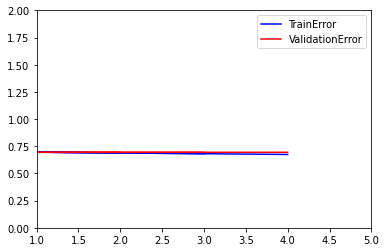

100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


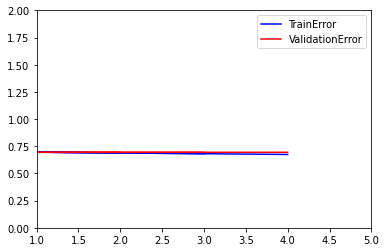

In [102]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(64, 30, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

report_train, trained_model = train(model, train_sample_dl, valid_sample_dl, 5, optimizer, loss_fn, device)

In [104]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="enhanced",
                    py_version="py3",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                  hyperparameters={
                    'vocab_size': new_vocab_size
                    }
                   )

In [105]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [106]:
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = estimator, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:loss',
                                               metric_definitions = [{"Name": "validation:loss","Regex": "BCELoss: (.*?);"}],# The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 10, # The total number of models to train
                                               max_parallel_jobs = 1, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'epochs': IntegerParameter(3, 10),
                                                    'hidden_dim': IntegerParameter(50, 200),
                                                    'embedding_dim': IntegerParameter(32, 64)
                                               })

In [107]:
xgb_hyperparameter_tuner.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [ ]:
xgb_hyperparameter_tuner.wait()

......

In [ ]:
xgb_hyperparameter_tuner.best_training_job()

In [3]:
best_estimator = sagemaker.estimator.Estimator.attach("sagemaker-pytorch-201206-2038-001-c5950043")
best_estimator.model_data

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-12-06 23:44:09 Starting - Preparing the instances for training
2020-12-06 23:44:09 Downloading - Downloading input data
2020-12-06 23:44:09 Training - Training image download completed. Training in progress.
2020-12-06 23:44:09 Uploading - Uploading generated training model
2020-12-06 23:44:09 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-12-06 23:42:51,299 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-12-06 23:42:51,301 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value validation:loss to Json.
Returning the value itself
2020-12-06 23:42:51,326 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-12-06 23:42:54,372 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-12-06 23:42:54,648 sagemaker-containers INFO     Module tr

's3://sagemaker-us-east-1-977053370764/sagemaker-pytorch-201206-2038-001-c5950043/output/model.tar.gz'

In [18]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=best_estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     py_version="py3",
                     source_dir='serve',
                     predictor_cls=StringPredictor)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [19]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------!

In [36]:
import glob
import os
from tqdm import tqdm

def test_reviews(data_dir='data/aclImdb', stop=1000):
    
    results = []
    ground = []
    
    # We make sure to test both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        
        files_read = 0
        
        print('Starting ', sentiment, ' files')
        
        # Iterate through the files and send them to the predictor
        for f in tqdm(files):
            with open(f) as review:
                # First, we store the ground truth (was the review positive or negative)
                if sentiment == 'pos':
                    ground.append(1)
                else:
                    ground.append(0)
                # Read in the review and convert to 'utf-8' for transmission via HTTP
                review_input = review.read().encode('utf-8')
                # Send the review to the predictor and store the results
                results.append(float(predictor.predict(review_input)))
                #print(results)
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [37]:
ground, results = test_reviews()

  0%|          | 0/12500 [00:00<?, ?it/s]

Starting  pos  files


  0%|          | 0/12500 [00:00<?, ?it/s]

Starting  neg  files


  8%|▊         | 999/12500 [05:06<58:53,  3.26it/s]  


for idx in tqdm(range(n_test_sample)):
    pr_data_X = test_tf_X[idx]
    pr_data_len = test_X_tf_len[idx]
    pr_data_pack = np.hstack((pr_data_len, pr_data_X))
    pr_data_pack = pr_data_pack.reshape(1, -1)
    pr_data = torch.from_numpy(pr_data_pack)
    pr_data = pr_data.to(device)
    model.eval()
    result = model(pr_data).detach().numpy()
    predicted_values.append(result)

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(ground, results)
fpr, tpr, _ = roc_curve(ground, results)

In [45]:
import matplotlib.pyplot as plt

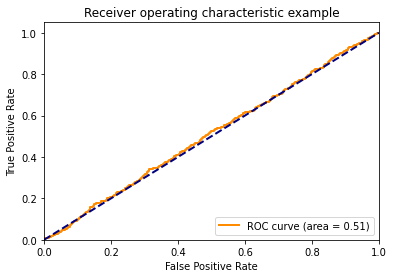

In [46]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [47]:
import numpy as np

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(ground, np.rint(results))

0.5025

In [49]:
confusion_matrix(ground, np.rint(results))

array([[443, 557],
       [438, 562]])